In [14]:
# packages

## Technical packages 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import random
import pandas as pd
import itertools
import scipy.stats
import math
import seaborn as sns

## Language packages
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.corpus import stopwords



In [16]:
########################################################
# Standard Functions
########################################################

def maketotal(dict_1):
    total = 0
    for item in dict_1:
        total += dict_1[item]
    return total  

def Jaccards(dict_1, dict_2):
    intersection = {} 
    for item in dict_1.keys():
        if item in dict_2.keys():
            intersection[item]=min(dict_1[item],dict_2[item])
            
    intersectiontot = maketotal(intersection)
    union = maketotal(dict_1) + maketotal(dict_2) - intersectiontot
    
    return intersectiontot/union

def time_it(somefunc,*arg,number_of_repeats=100,**kwarg):
    list_=[]

    #in each iteration the runtime of the function is noted and appended to a list
    for i in range(number_of_repeats):
        starttime = time.time()
        somefunc(*arg,**kwarg)
        endtime = time.time()
        list_.append(endtime-starttime)

    a = 0
    for i in list_:#finds the average of the list
        a += i

        mean = a/len(list_)

    return mean

In [175]:
# Generate variable leanght documents: 
class DocumentGenerator:
    def __init__(self,length = 10000,corpus = brown,filler_words = False,max_difference = False):
        self.word_reservoir = list(itertools.chain.from_iterable(corpus.sents()[:length]))
        
        if filler_words:
            pass
        else:
            self.word_reservoir = [word for word in self.word_reservoir if word not in stopwords.words('english')]
        self.documents = []
        self.max_difference = max_difference


    def total_words(self):
        return self.word_reservoir


    def generate_documents(self, no_doc = 10,min_length = 50,max_length = 150):
        word_list = self.remove_punctuation(self.word_reservoir)
        document_length = [int(x) for x in np.linspace(min_length,max_length,no_doc)]
        
        for i in document_length:
            document_pairs = []

            rand_doc1 = random.choices(word_list,k=i)
            rand_doc2 = []

            if self.max_difference:
                while len(rand_doc2) != len(rand_doc1):
                    word = random.choices(word_list,k=1)[0]
                    if word in rand_doc1:
                        continue
                    else:
                        rand_doc2.append(word)
            else:
                rand_doc2 = random.choices(word_list,k=i)


            document_pairs.append((self.tokenize(rand_doc1)))
            document_pairs.append((self.tokenize(rand_doc2)))
        
            self.documents.append(document_pairs)

        return self.documents
        

    @staticmethod
    def remove_punctuation(docs):
        for i in range(len(docs)):
            characters_to_remove = string.punctuation + string.digits 
            remove_table = str.maketrans('', '', characters_to_remove)
            docs[i] = docs[i].translate(remove_table)

        word_list = list(filter(None, docs))
        word_list = [x.lower() for x in word_list]

        return word_list

    @staticmethod
    def tokenize(l: list):
        tokenized_dict = {}
        for i in range(len(l)):
            if l[i] in tokenized_dict:
                pass
            else:
                tokenized_dict[l[i]] = l.count(l[i])
            
        return tokenized_dict




In [176]:
documents = DocumentGenerator(length=10000,filler_words=False)
list_of_docs = documents.generate_documents(100,min_length=500,max_length=2000)

In [177]:
xs = []
ys = []

for i in range(len(list_of_docs)):
    ys.append(time_it(Jaccards, list_of_docs[i][0],list_of_docs[i][1]))
    xs.append(max((len(list_of_docs[i][0]),len(list_of_docs[i][1]))))



The empirical Analysis of the Jaccard Similarity has yielded a value of 1.0563895646545483 for the slope and a value of 3.5980272725175e-16 for the computer constant


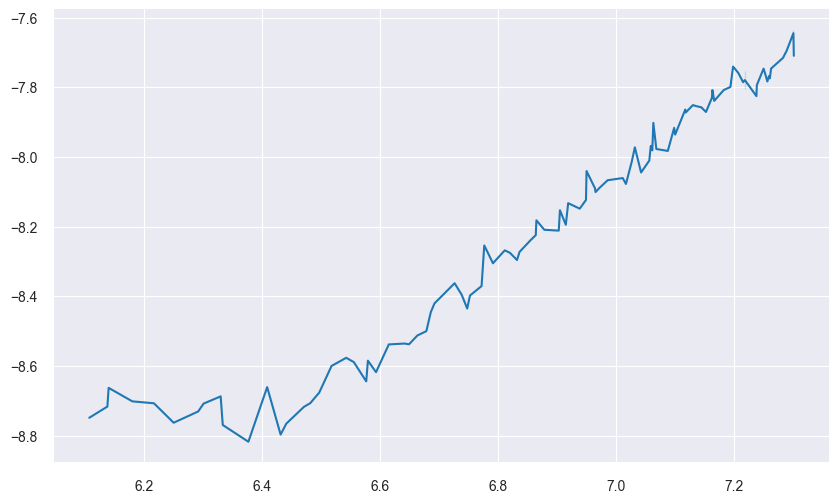

In [181]:
########################################################
# Plotting the results and summary staistics
########################################################


logx = [np.log(x) for x in xs]
logy = [np.log(y) for y in ys]

plt.figure(figsize=(10,6),dpi=100)
sns.set_style("darkgrid")
sns.lineplot(x=logx, y=logy)
sns.despine(offset=5,trim=True)

slope_jaccard,intercept, r_value, p_value ,std_err = scipy.stats.linregress(logx,logy)
computer_constant = np.power(10,intercept)

print(f'The empirical Analysis of the Jaccard Similarity has yielded a value of {slope_jaccard} for the slope and a value of {computer_constant} for the computer constant')

In [145]:
########################################################
# Cosine Similarity for dense vectors
########################################################

class DenseCosineSimilarity:
    def __init__(self,length = 1000,corpus = brown,max_difference = False):
        self.word_reservoir = self.remove_punctuation([word for word in list(itertools.chain.from_iterable(corpus.sents()[:length])) if word not in stopwords.words('english')])
        self.v1 = None
        self.v2 = None

    def create_documents_vectors(self,size = 50):
        document_1 = random.choices(self.word_reservoir,k = size)
        document_2 = random.choices(self.word_reservoir,k = size)

        vector_size = len(set(document_1 + document_2))
        self.v1 = np.zeros(vector_size).reshape(-1,vector_size)
        self.v2 = np.zeros(vector_size).reshape(-1,vector_size)

        combined_document = list(set(sorted(document_1 + document_2)))

        for i in range(vector_size):
            self.v1[0][i] = document_1.count(combined_document[i])
            self.v2[0][i] = document_2.count(combined_document[i])

        return f'Documents of size {size} created successfully.'


    def compute_cosine_similarity(self):
        return self.naiveCosine(self.v1, self.v2)


    @staticmethod
    def remove_punctuation(docs):
        for i in range(len(docs)):
            characters_to_remove = string.punctuation + string.digits 
            remove_table = str.maketrans('', '', characters_to_remove)
            docs[i] = docs[i].translate(remove_table)

        word_list = list(filter(None, docs))
        word_list = [x.lower() for x in word_list]

        return word_list


    @staticmethod
    def naiveCosine(vector_1,vector_2):
        numerator = 0
        for i in range(len(vector_1)):
            numerator += vector_1[0][i]*vector_2[0][i]

        norm_v1 = np.sqrt(np.sum(vector_1**2))
        norm_v2 = np.sqrt(np.sum(vector_1**2))

        denominator = norm_v1*norm_v2

        return round(numerator/denominator,6)


            

In [146]:
CosineAnalysis = DenseCosineSimilarity()
CosineAnalysis.create_documents_vectors()
CosineAnalysis.compute_cosine_similarity()

0.0

In [183]:
cosine_xs = []
cosine_ys = []

# Hyperparameter
min_len = 500
max_len = 5000
np_doc = 1000

document_lengths = [round(x) for x in np.linspace(min_len, max_len, np_doc)]

CosineAnalysis = DenseCosineSimilarity()                                        # provides the underlying words used for the documents

for lengths in document_lengths:
    cosine_xs.append(lengths)
    CosineAnalysis.create_documents_vectors()
    CosineAnalysis.compute_cosine_similarity()
    
    cosine_ys.append(time_it(CosineAnalysis.compute_cosine_similarity,number_of_repeats=500))

    

-0.037017562501919836 -10.451611990715726 -0.23811312650600663 2.3404199069001788e-14 0.004779523703818058


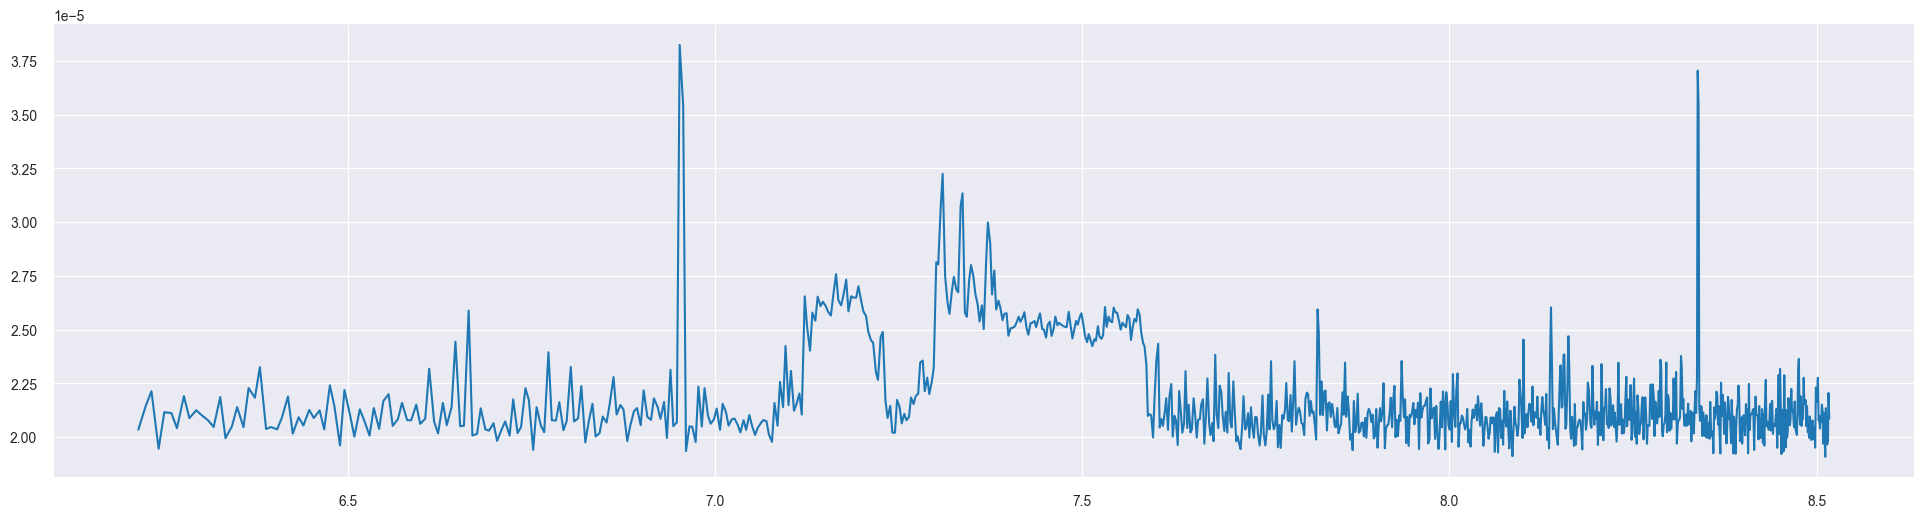

In [186]:
cos_logx = [np.log(x) for x in cosine_xs]
cos_logy = [np.log(y) for y in cosine_ys]

plt.figure(figsize=(24,6),dpi=100)
sns.set_style("darkgrid")
sns.lineplot(x=cos_logx, y=cosine_ys)
sns.despine(offset=5,trim=True)

slope_jaccard,intercept, r_value, p_value ,std_err = scipy.stats.linregress(cos_logx,cos_logy)
print(slope_jaccard,intercept, r_value, p_value ,std_err)

In [187]:
########################################################
# Cosine Similarity for dense vectors
########################################################

class DenseRepresentation: # import it into the class above
    def __init__(self,data: list):
        self.data = sorted(list(set(data)))
        self.list_of_dense_vectors = []
        
    def fill_vector(self,input_dict: dict):
        data_zero_vector = np.zeros(shape=(1,len(self.data)))
        for idx, word in enumerate(self.data):
            if word in input_dict.keys():
                data_zero_vector[0][idx] = input_dict[word]

        return data_zero_vector


    def dense_vector_generator(self,list_of_docs: list):
        list_of_dense_vectors = []

        for document_pair in list_of_docs:
            vector_pairs = []
            
            for j in document_pair:
                vector_pairs.append(self.fill_vector(input_dict = j))

            list_of_dense_vectors.append(vector_pairs)

        return list_of_dense_vectors



def dense_cosine_total(vector_pairs: list):
    for i in range(len(vector_pairs)):
        numerator = vector_pairs[i][0] @ vector_pairs[i][1].T
        denominator = np.linalg.norm(vector_pairs[i][0]) * np.linalg.norm(vector_pairs[i][1])

        print(numerator/denominator)


def dense_cosine(vector_1: np.array, vector_2: np.array):
    numerator = np.dot(vector_1, vector_2.T)
    denominator = np.linalg.norm(vector_1) * np.linalg.norm(vector_2)

    return numerator/denominator
        

# DensRep = DenseRepresentation(word_list)
# dense_vectors = DensRep.dense_vector_generator(list_of_docs=list_of_docs)


# print(dense_vectors[0][1].shape)


In [188]:
documents = DocumentGenerator(length=100,filler_words=False,max_difference=False)
list_of_docs = documents.generate_documents(500,min_length=500,max_length=1500)
word_list = documents.total_words()


DensRep = DenseRepresentation(word_list)
dense_vectors = DensRep.dense_vector_generator(list_of_docs=list_of_docs)

-0.037017562501919836 -9.173787735357983 -0.6600896970997666 7.15915081734736e-64 0.016823391130025817
8.544921875e-06


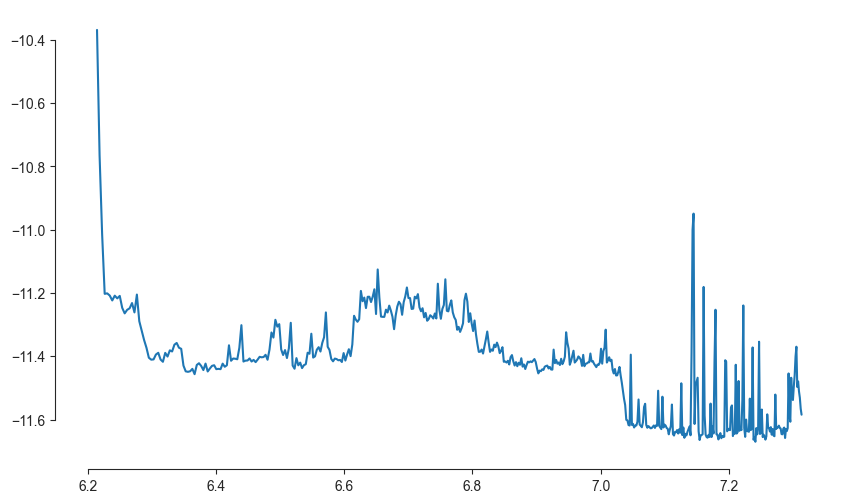

In [189]:
xs = np.linspace(500,1500,500)
ys = []


for i in range(len(dense_vectors)):
    ys.append(time_it(dense_cosine, dense_vectors[i][0],dense_vectors[i][1]))
    # xs.append(max((np.sum(dense_vectors[i][0]),np.sum(dense_vectors[i][1]))))

logx = [np.log(x) for x in xs]
logy = [np.log(y) for y in ys]

fig2 = plt.figure(figsize=(10,6),dpi=100)
sns.set_style("ticks")
sns.lineplot(x=logx, y=logy)
sns.despine(offset=5,trim=True)

slope_cosine,intercept, r_value, p_value ,std_err = scipy.stats.linregress(logx,logy)
print(slope_jaccard,intercept, r_value, p_value ,std_err)

print(min(ys))

In [190]:
def cosine_dic(dic1,dic2):
    numerator = 0
    dena = 0
    for key1,val1 in dic1.items():
        numerator += val1*dic2.get(key1,0.0)
        dena += val1*val1
    denb = 0
    for val2 in dic2.values():
        denb += val2*val2
    return numerator/math.sqrt(dena*denb)

-0.037017562501919836 -12.353608960002575 0.6800786067758988 3.822898664843961e-69 0.024956766148937132


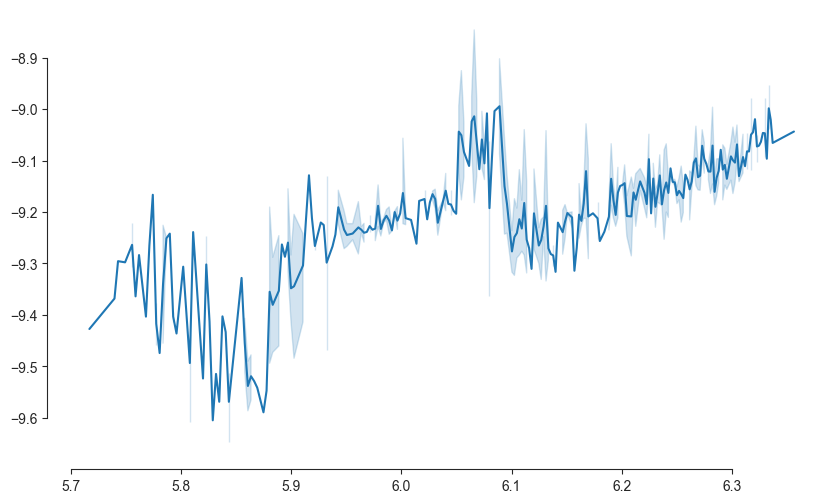

In [191]:
xs = []
ys = []

for i in range(len(list_of_docs)):
    ys.append(time_it(cosine_dic, list_of_docs[i][0],list_of_docs[i][1]))
    xs.append(max((len(list_of_docs[i][0]),len(list_of_docs[i][1]))))

logx = [np.log(x) for x in xs]
logy = [np.log(y) for y in ys]


plt.figure(figsize=(10,6),dpi=100)
sns.set_style("ticks")
sns.lineplot(x=logx, y=logy)
sns.despine(offset=5,trim=True)




# plt.scatter(logx,logy)
slope_cosine,intercept, r_value, p_value ,std_err = scipy.stats.linregress(logx,logy)
print(slope_jaccard,intercept, r_value, p_value ,std_err)

# plt.show()